In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical

In [96]:
df = pd.read_csv("cap4773-final-dataset.csv")

In [97]:
def overnight_tweet(hour):
  if hour in range(5) or hour == 23:
    return 1
  else:
    return 0

In [98]:
df['overnight'] = df['hour_of_day'].apply(lambda x: overnight_tweet(x))

In [99]:
df = df.sort_values(by='post_created')

In [100]:
columns_to_keep = ['user_id', 'emotion_encoded', 'weekend', 'overnight']

df = df[columns_to_keep]

In [101]:
df.head()

,user_id,emotion_encoded,weekend,overnight
0,60868031,0.0,0,0
1,60868031,0.0,0,0
2,60868031,0.0,0,0
3,60868031,0.0,0,0
4,60868031,0.0,0,1


In [102]:
print(df['emotion_encoded'].value_counts())

emotion_encoded
0.0    14573
1.0     3147
2.0     1445
3.0      484
4.0       91
Name: count, dtype: int64


In [103]:
grouped_users = list(df.groupby('user_id'))
np.random.shuffle(grouped_users)

In [104]:
total_groups = len(grouped_users)
train_size = int(0.7 * total_groups)
val_size = int(0.15 * total_groups)
test_size = total_groups - train_size - val_size

train_groups = grouped_users[:train_size]
val_groups = grouped_users[train_size:train_size + val_size]
test_groups = grouped_users[train_size + val_size:]

In [105]:
def generate_row(batch):
    row = [row[1:].tolist() for index, row in batch.iloc[:-1].iterrows()]

    label = batch.iloc[-1]['emotion_encoded']

    return row, label


In [106]:
def split_group(group):
    batch_size = 10

    num_batches, remaining_rows = divmod(len(group), batch_size)

    batches = [
        group.iloc[i * batch_size:(i+1) * batch_size]
        for i in range(num_batches)
    ]

    if remaining_rows > 0:
        batches.append(group.iloc[num_batches * 10:])

    return batches

In [119]:
def populate_data(groups):
    X, y = [], []
    for user_id, group in groups:
        for batch in split_group(group):
            if len(batch) == 10:
                row, label = generate_row(batch)
                X.append(row)
                y.append(label)
    return X, y

In [120]:
X_train, y_train = populate_data(train_groups)
X_val, y_val = populate_data(val_groups)
X_test, y_test = populate_data(test_groups)

In [121]:
assert len(X_train) == len(y_train), "Lengths of X_train and y_train are not equal."

assert len(X_val) == len(y_val), "Lengths of X_val and y_val are not equal."

assert len(X_test) == len(y_test), "Lengths of X_test and y_test are not equal."


In [115]:
X_train_flat = [sum(sequence, []) for sequence in X_train]

In [347]:
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


# Convert numerical labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train, num_classes=6)
y_val_onehot = to_categorical(y_val, num_classes=6)
y_test_onehot = to_categorical(y_test, num_classes=6)


In [385]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_onehot)

In [386]:
X_train_resampled = np.array(X_train_resampled)
X_train_resampled = X_train_resampled.reshape(-1, 9, 3)
X_train_resampled = X_train_resampled.tolist()

In [387]:
model = Sequential([
    LSTM(32, input_shape=(9, 3)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [388]:
from keras.optimizers import Adam

# Define a new learning rate
new_learning_rate = 0.005  # You can adjust this value as needed

# Compile the model with the new learning rate
opt = Adam(learning_rate=new_learning_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [389]:
y_train_resampled = np.array(y_train_resampled).astype(float).tolist()
y_val_onehot = np.array(y_val_onehot).astype(float).tolist()
y_test_onehot = np.array(y_test_onehot).astype(float).tolist()


for encoded_label in y_train_resampled:
  encoded_label.append(0.0)

print(y_train_resampled)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0

In [390]:
print(y_val_onehot)
print(len(y_test))
print(len(X_test))
print(len(X_train_resampled))

print(type(y_train_resampled))
print(type(y_val_onehot))
print(type(y_test_onehot))
print(type(X_train_resampled))
print(type(X_val))
print(type(X_test))

assert all(all(x is not None and not np.isinf(x) for x in sublist) for sublist in y_val_onehot), "Some sublists contain null or inf values"

assert all(len(sublist) == 6 for sublist in y_val_onehot), "All lists are not of length 5"
assert all(len(sublist) == 6 for sublist in y_test_onehot), "All lists are not of length 5"
assert all(len(sublist) == 6 for sublist in y_train_resampled), "All lists are not of length 5"

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0

In [391]:
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_onehot),
    callbacks=[early_stopping]
)


Epoch 1/100
131/131 [==============================] - 4s 12ms/step - loss: 1.5934 - accuracy: 0.2748 - val_loss: 1.5270 - val_accuracy: 0.1015
Epoch 2/100
131/131 [==============================] - 1s 7ms/step - loss: 1.4233 - accuracy: 0.3688 - val_loss: 1.4175 - val_accuracy: 0.2868
Epoch 3/100
131/131 [==============================] - 1s 7ms/step - loss: 1.2548 - accuracy: 0.4532 - val_loss: 1.4073 - val_accuracy: 0.1853
Epoch 4/100
131/131 [==============================] - 1s 7ms/step - loss: 1.1055 - accuracy: 0.5165 - val_loss: 1.4413 - val_accuracy: 0.0812
Epoch 5/100
131/131 [==============================] - 1s 7ms/step - loss: 0.9912 - accuracy: 0.5619 - val_loss: 1.3288 - val_accuracy: 0.3376
Epoch 6/100
131/131 [==============================] - 1s 7ms/step - loss: 0.9130 - accuracy: 0.5827 - val_loss: 1.3467 - val_accuracy: 0.2462
Epoch 7/100
131/131 [==============================] - 1s 7ms/step - loss: 0.8780 - accuracy: 0.5993 - val_loss: 1.1985 - val_accuracy: 0.756

In [392]:
print(len(y_test_onehot))
print(len(X_test))

370
370


In [393]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)
metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {metrics[0]}")
print(f"Recall: {metrics[1]}")
print(f"F1 Score: {metrics[2]}")

12/12 [==============================] - 0s 3ms/step
Accuracy: 0.27297297297297296
Precision: 0.5276181659226215
Recall: 0.27297297297297296
F1 Score: 0.33032948745584534


Text(0.5, 1.0, 'Training vs. Validation Loss')

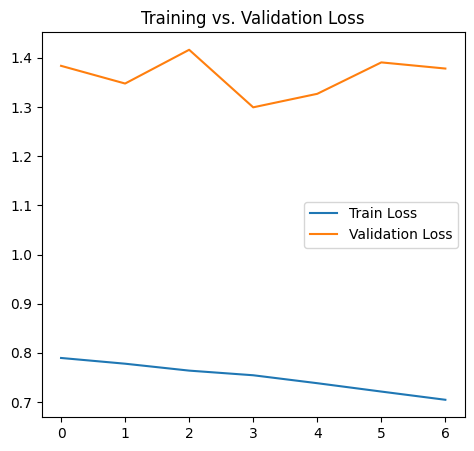

In [216]:
#Training loss vs validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

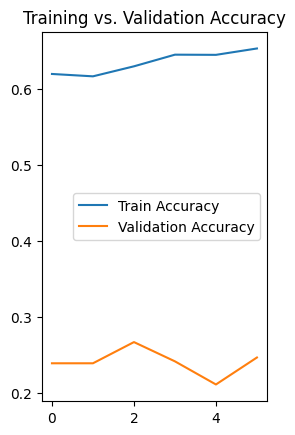

In [209]:
#Training accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

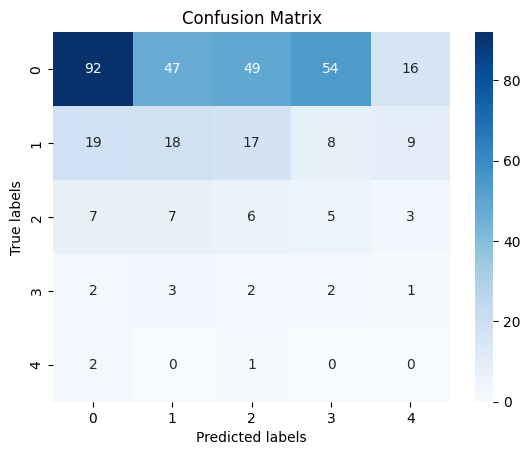

In [210]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()